In [8]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

random.seed(777)
np.random.seed(777)
torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

In [10]:
train_transform = transforms.Compose([
    transforms.Resize(256), # size
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
data_transforms={'train':train_transform, 'val':val_transform}

In [11]:
data_dir = "data/dog_cat"
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val'])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names = train_dataset.classes

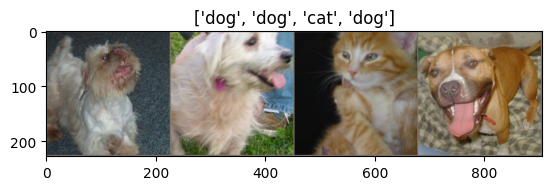

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) 
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) 
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train'])) 

# Make a grid from batch
out = torchvision.utils.make_grid(inputs) 
imshow(out, title=[class_names[x] for x in classes])

## classifier만 학습

In [13]:
def train_model(model, criterion, optimizer, model_name, num_epochs=25):
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # save model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                content = {
                    'epoch': epoch,
                    'acc': epoch_acc,
                    'model': model.state_dict()
                }
                torch.save(content, f'{model_name}.pt')

    print('Best val Acc: {:4f}'.format(best_acc))

In [14]:
def visualize_model(model, num_images=6):
    model.eval()
    images_so_far = 0
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                plt.subplot(num_images//2, 2, images_so_far)
                plt.axis('off')
                plt.title('real: {} | predicted: {}'.format(class_names[labels[j]],
                                                            class_names[preds[j]]))
                img = inputs.cpu().data[j].permute(1,2,0)*std+mean
                img = np.clip(img, 0, 1)
                plt.imshow(img)

                if images_so_far == num_images:
                    return

In [16]:
resnet = models.resnet18(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False

num_in = resnet.fc.in_features
resnet.fc = nn.Linear(num_in,2)

resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.001)
num_epochs = 10

In [17]:
train_model(resnet,
            criterion, 
            optimizer,
            model_name='resnet',
            num_epochs=num_epochs)

Epoch 1/10
----------
train Loss: 0.5093 Acc: 0.7129
val Loss: 0.1085 Acc: 0.9706
Epoch 2/10
----------
train Loss: 0.3709 Acc: 0.8366
val Loss: 0.0860 Acc: 0.9804
Epoch 3/10
----------
train Loss: 0.3757 Acc: 0.8366
val Loss: 0.1040 Acc: 0.9706
Epoch 4/10
----------
train Loss: 0.4092 Acc: 0.7871
val Loss: 0.0638 Acc: 0.9804
Epoch 5/10
----------
train Loss: 0.3196 Acc: 0.8713
val Loss: 0.0727 Acc: 0.9706
Epoch 6/10
----------
train Loss: 0.3104 Acc: 0.8614
val Loss: 0.0783 Acc: 0.9706
Epoch 7/10
----------
train Loss: 0.3174 Acc: 0.8960
val Loss: 0.0580 Acc: 0.9902
Epoch 8/10
----------
train Loss: 0.2591 Acc: 0.8911
val Loss: 0.1140 Acc: 0.9510
Epoch 9/10
----------
train Loss: 0.4080 Acc: 0.8069
val Loss: 0.1304 Acc: 0.9608
Epoch 10/10
----------
train Loss: 0.4046 Acc: 0.8218
val Loss: 0.1199 Acc: 0.9608
Best val Acc: 0.990196


In [18]:
ckpt = torch.load('resnet.pt')
resnet.load_state_dict(ckpt['model'])

<All keys matched successfully>

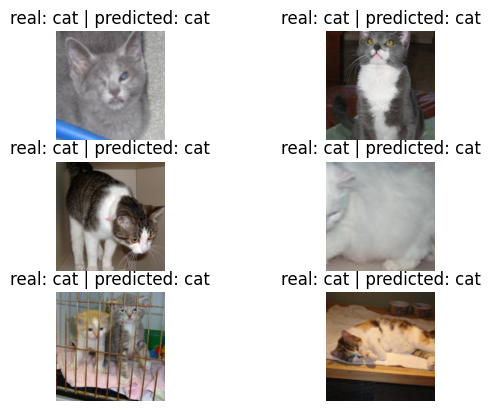

In [19]:
visualize_model(resnet)

## 전체 학습

In [20]:
resnet = models.resnet18()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 2)
resnet.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
num_epochs = 10

In [21]:
train_model(resnet,
            criterion, 
            optimizer,
            model_name='resnet_all',
            num_epochs=num_epochs)

Epoch 1/10
----------
train Loss: 0.9164 Acc: 0.5446
val Loss: 1.8150 Acc: 0.5490
Epoch 2/10
----------
train Loss: 0.7772 Acc: 0.5594
val Loss: 0.7880 Acc: 0.5294
Epoch 3/10
----------
train Loss: 0.7280 Acc: 0.5644
val Loss: 0.8309 Acc: 0.6078
Epoch 4/10
----------
train Loss: 0.6841 Acc: 0.5891
val Loss: 1.0658 Acc: 0.4706
Epoch 5/10
----------
train Loss: 0.7421 Acc: 0.4950
val Loss: 0.7389 Acc: 0.5882
Epoch 6/10
----------
train Loss: 0.6875 Acc: 0.5693
val Loss: 0.7961 Acc: 0.5294
Epoch 7/10
----------
train Loss: 0.7113 Acc: 0.5693
val Loss: 0.8548 Acc: 0.5392
Epoch 8/10
----------
train Loss: 0.7390 Acc: 0.5297
val Loss: 0.6727 Acc: 0.5980
Epoch 9/10
----------
train Loss: 0.7509 Acc: 0.5198
val Loss: 0.7722 Acc: 0.5196
Epoch 10/10
----------
train Loss: 0.6649 Acc: 0.5545
val Loss: 0.6516 Acc: 0.6078
Best val Acc: 0.607843


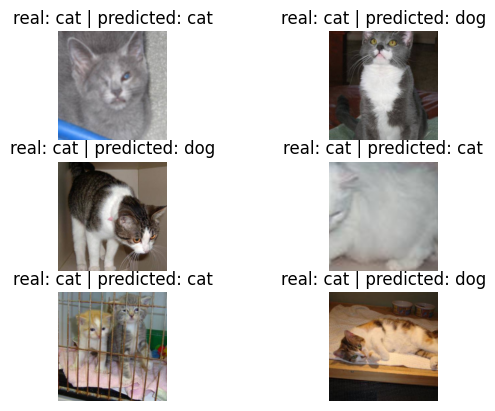

In [23]:
ckpt = torch.load('resnet_all.pt')
resnet.load_state_dict(ckpt['model'])
visualize_model(resnet)